In [1]:
#连接到谷歌云盘
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [21]:
import os
os.chdir("/content/gdrive/My Drive/机器学习实战/gan项目")

In [22]:
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

import numpy as np
import pandas as pd 
import os

#to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "gan-start"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 在Fashion MNIST数据集上的简单实现

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [12]:
np.random.seed(42)
tf.random.set_seed(42)

coding_size=23

generator=keras.models.Sequential([
    keras.layers.Dense(100,activation='selu',input_shape=[coding_size]),
    keras.layers.Dense(200,activation='selu'), 
    keras.layers.Dense(28*28,activation='sigmoid'), #0-1
    keras.layers.Reshape([28,28]) #imgae size
])

discriminator=keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(200,activation='selu'),
    keras.layers.Dense(100,activation='selu'),
    keras.layers.Dense(1,activation='sigmoid')                                   
])

gan=keras.models.Sequential([generator,discriminator])

In [13]:
discriminator.compile(loss='binary_crossentropy',optimizer='rmsprop')
discriminator.trainable=False #判别器第二个阶段不训练
gan.compile(loss='binary_crossentropy',optimizer='rmsprop')

In [14]:
#创建一个数据集遍历图像
batch_size=32 
#from_tensor_slices特征切片,切片的范围是从最外层维度开始的.
dataset=tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset=dataset.batch(batch_size,drop_remainder=True).prefetch(1)

In [15]:
#图像展示函数
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1) #squeeze 函数：从数组的形状中删除单维度条目，即把shape中为1的维度去掉
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [16]:
#自定义训练循环
def train_gan(gan,dataset,batch_size,coding_size,n_epochs=50):
  generator,discriminator=gan.layers
  for epoch in range(n_epochs):
    print('Epoch{}/{}'.format(epoch+1,n_epochs))
    for X_batch in dataset:
      #1.训练判别器
      noise=tf.random.normal(shape=[batch_size,coding_size])
      generated_images=generator(noise)
      X_fake_and_real=tf.concat([generated_images,X_batch],axis=0)
      y1=tf.constant([[0.]]*batch_size+[[1.]]*batch_size)
      discriminator.trainable=True
      #train_on_batch 这个 api，对一个 mini-batch 的数据进行梯度更新
      discriminator.train_on_batch(X_fake_and_real,y1)
      #2.训练生成器
      noise=tf.random.normal(shape=[batch_size,coding_size])
      y2=tf.constant([[1.]]*batch_size)
      discriminator.trainable=False
      gan.train_on_batch(noise,y2)
  plot_multiple_images(generated_images,8)
  plt.show()

Epoch1/1


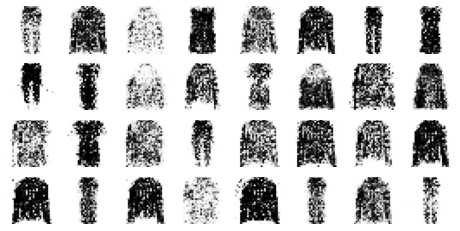

In [17]:
train_gan(gan,dataset,batch_size,coding_size,n_epochs=1)

Saving figure gan_generated_epoch1


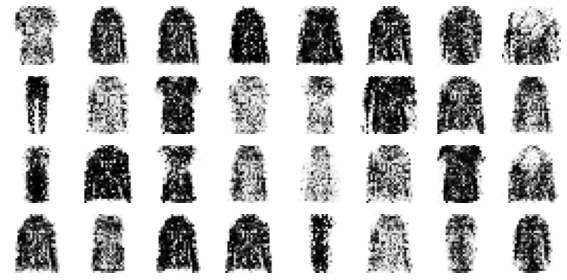

In [23]:
tf.random.set_seed(42)
np.random.seed(42)

noise=tf.random.normal(shape=[batch_size,coding_size])
generated_images=generator(noise)
plot_multiple_images(generated_images,8)
save_fig("gan_generated_epoch1")

In [ ]:
train_gan(gan,dataset,batch_size,coding_size)